## Lab5
netid: yxw190015

name: Yile Wang

In [1]:
import networkx as nx
import networkx.algorithms.community as nx_comm
from numpy import zeros, dot, array
import pickle
import matplotlib.pyplot as plt
import json
import string
import time
import re
import numpy as np


## Modularity

The first function below calculates modularity for *directed* networks and also returns the maximum modularity value $Q_{\text{max}}$ (NetworkX's modularity function does not report the $Q_{\text{max}}$ value). The second function calculates scalar assortativity (NetworkX's assortativity functions differ from our book definition). 

In [2]:
def modularity(G,c):
    d = dict()
    for k,v in enumerate(c):
        for n in v:
            d[n] = k
    L = 0
    for u,v,data in G.edges.data():
        L += data['weight']
    Q, Qmax = 0,1
    for u in G.nodes():
        for v in G.nodes():
            if d[u] == d[v]:
                Auv = 0
                if G.has_edge(v,u):
                    Auv = G[v][u]['weight']
                Q += ( Auv - G.in_degree(u,weight='weight')*G.out_degree(v,weight='weight')/L )/L
                Qmax -= ( G.in_degree(u,weight='weight')*G.out_degree(v,weight='weight')/L )/L
    return Q, Qmax

def scalar_assortativity(G,d):
    x = zeros(G.number_of_nodes())
    for i,n in enumerate(G.nodes()):
        x[i] = d[n]

    A = array(nx.adjacency_matrix(G).todense().T)
    M = 2*A.sum().sum()
    ki = A.sum(axis=1) #row sum is in-degree
    ko = A.sum(axis=0) #column sum is out-degree
    mu = ( dot(ki,x)+dot(ko,x) )/M

    R, Rmax = 0, 0
    for i in range(G.number_of_nodes()):
        for j in range(G.number_of_nodes()):
             R += ( A[i,j]*(x[i]-mu)*(x[j]-mu) )/M
             Rmax += ( A[i,j]*(x[i]-mu)**2 )/M

    return R, Rmax

In [3]:
G = nx.read_weighted_edgelist('fifa1998.edgelist',create_using=nx.DiGraph)

c = {
    'group1': {'Argentina','Brazil','Chile','Mexico','Colombia','Jamaica','Paraguay'},
    'group2': {'Japan','SouthKorea'},
    'group3': {'UnitedStates'},
    'group4': {'Nigeria','Morocco','SouthAfrica','Cameroon','Tunisia','Iran','Turkey'},
    'group5': {'Scotland','Belgium','Austria','Germany','Denmark','Spain','France','GreatBritain','Greece','Netherlands','Norway','Portugal','Italy','Yugoslavia','Romania','Bulgaria','Croatia','Switzerland'}
    }
Q, Qmax = modularity(G,c.values())
print('FIFA exports by geographic region is assortatively mixed: %1.4f/%1.4f' % (Q,Qmax))

c = {
    'exporters': {'Argentina','Brazil','Chile','Colombia','Mexico','Scotland','Belgium','Austria','Denmark','France','Greece','Netherlands','Portugal','Yugoslavia','Croatia','Jamaica','Cameroon','Nigeria','Morocco','Tunisia'},
    'importers': {'Paraguay','SouthKorea','UnitedStates','SouthAfrica','Iran','Turkey','Germany','Spain','GreatBritain','Norway','Italy','Romania','Bulgaria','Switzerland','Japan'}
    }
Q, Qmax = modularity(G,c.values())
print('FIFA exports by importers/exporters is disassortatively mixed: %1.4f/%1.4f' % (Q,Qmax))

FIFA exports by geographic region is assortatively mixed: 0.1200/0.5505
FIFA exports by importers/exporters is disassortatively mixed: -0.0185/0.5748


### Describing why I see the values
Firstly I need to define what's the meaning of `Q` and `Qmax`. The `Q` means the modularity, whose definition is that the fraction of edges that connect nodes of the same type minus fraction of edges if it's random graph. If the `Q` is higher, it means that it is more likely an assortative mixing in the graph (More organized). The `Qmax` represents an ideal situation that the modularity score of every edge is between nodes of same type. 

The positive value of the `Q` means that it exists the assortativity in the network.

The negative value of the `Q` means that it doesn't exist the assortativity in the network (disassortativity).


In the FIFA network analysis, I can know that if we group players by geographic region,the `Q` is larger than 0, which means that there is higher fraction that similar type of nodes are connected. The real life situation is that there are more players trading within the same continent. 

For the second group, importers and exporters network, the modularity score `Q` is negative, which means that the edges between nodes are not likely coming from the same type of nodes, which makes sense here because the condition to make connections between nodes is that player from country A is playing at country B now. In the importers/exporters network, there may have fewer connections between nodes both in the importers/exporters type (There are more connections/edges between importers and exporters!). That's the reason why it has negative modularity scores.

For the similar `Qmax`, it is because that the network is still the same network with same nodes and edges. The only thing different is the $\delta(c_i, c_j)$, which means all the edges between nodes of same type. By grouping nodes in different way, there might be slightly different value for $\delta(c_i, c_j)$, but overall the two `Qmax` should be similar.

## Assortativity

In [4]:
gdp = pickle.load(open('gdp.pkl','rb'))
life_expectancy = pickle.load(open('life_expectancy.pkl','rb'))
tariff = pickle.load(open('tariff.pkl','rb'))

G = nx.read_weighted_edgelist('world_trade_2014.edgelist',create_using=nx.DiGraph)

R, Rmax = scalar_assortativity(G,gdp)
print('Assortativity by GDP: %1.4f' % (R/Rmax))
R, Rmax =  scalar_assortativity(G,life_expectancy)
print('Assortativity by life expectancy: %1.4f' % (R/Rmax))
R, Rmax =  scalar_assortativity(G,tariff)
print('Assortativity by tariff: %1.4f' % (R/Rmax))

Assortativity by GDP: -0.0005
Assortativity by life expectancy: 0.1281
Assortativity by tariff: 0.1191


### Describe world trading system and reason
First we need to know what the edges mean in the network. From the definition of scalar assortativity, it measures how much two variables vary together. In the world trading network, the edge is defined as the trading value between two countries. 

The scalar assortativity is to describe the covariance between nodes $x_i$ and $x_j$. In simple words, it captures how much $x_i$ node is different from the mean. The $\mu$ is the mean, which is the weighted average of scalar node value, proportioned to their degree. The concept of the `R/Rmax` is similar with `Q/Qmax`.

From the assortativity statistics, we can know that GDP has almost no salient effect to the trading behaviors between two countries. The `R/Rmax` of the GDP is close to random graph, which means that `GDP` of a country is not an important factor to affect the trading relationship. A potential reason is that GDP doesn't mean the average wealth level for individuals. For example, Taiwan and Japanese may not have large number in `GDP` but the citizens are wealth than many of countries with high `GDP`. 

However, the life expectancy and tariff could be important factors, which make senses too. To some extent, the life expectancy can reflect the aging population distribution in the country. The increase of the life expectancy can also reflect the development of economic system and medical system for a country. These can be an important indicator for the value of goods they trades, then influencing the total trade values. Also, countries with similar aging population may have similar demand and requirment for most of the people, which could be an factor for the positive assortativity value here; The tariff is another important factor for trading. An equal (similiar level) of the tariff between two countries can be easier to reach an equilibrium then trading more goods to each other. If the difference of tariff between two countries are huge (I taxed you 10% and you taxed me 50%), there are less likely to have a stable and large amount of trading between two countries.

### Algebraic activity to show the following simplification

The steps are here:

$$
\frac{1}{2m}\sum_{i=1}^{n}\sum_{j=1}^{n} A_{ij}(x_i - \mu)(x_j - \mu) = \frac{1}{2m}\sum_{i=1}^{n}\sum_{j=1}^{n} A_{ij}(x_ix_j - \mu x_i - \mu x_j + \mu ^2) 
$$

 
$$
\frac{1}{2m}\sum_{i=1}^{n}\sum_{j=1}^{n} A_{ij}x_ix_j - \frac{1}{2m}\sum_{i=1}^{n}\sum_{j=1}^{n} A_{ij}\mu x_i - \frac{1}{2m}\sum_{i=1}^{n}\sum_{j=1}^{n} A_{ij}\mu x_j + \frac{1}{2m}\sum_{i=1}^{n}\sum_{j=1}^{n} A_{ij}\mu ^2
$$

we know that the eqaution of the degree is

$$
k_i = \sum_{j=1}^n A_{ij}
$$

And the equation of $\mu$ is

$$
\mu = \frac{1}{2m}\sum_{i=1}^n k_ix_i
$$

so the $\mu$ can be re-written as:

$$
\mu = \frac{1}{2m} \sum_{i=1}^n \sum_{j=1}^n A_{ij}x_i
$$

Then we can try to subtitude the $\mu$ into the original equation:

$$
\frac{1}{2m}\sum_{i=1}^{n}\sum_{j=1}^{n} A_{ij}x_ix_j - \mu^2 - \mu^2 + \frac{1}{2m}\sum_{i=1}^{n}\sum_{j=1}^{n} A_{ij}\mu ^2
$$

For the last term, we can rewrite it based on the equation of calculating the degree, so we have:

$$
\frac{1}{2m} \sum_{i=1}^n k_i \mu^2
$$
We know that actually $2m$ is the sum of the degree:

$$
2m = \sum_{i=1}^n k_i
$$

so, we have 

$$
\frac{1}{2m} \sum_{i=1}^n k_i \mu^2 = \mu^2
$$

Then, we can summarize our derviation to have this equation as our final results

$$
\frac{1}{2m}\sum_{i=1}^n \sum_{j=1}^n A_{ij}x_ix_j-\mu^2-\mu^2 + \mu{^2}= \frac{1}{2m}\sum_{i=1}^n \sum_{j=1}^n A_{ij}x_ix_j-\mu^2
$$


## Partitioning 

### cut size increase before it decreases to a value smaller than original
We need to know all the gains (decrease or increase of the cut size) before we make decision which pairs of nodes need to be swapped. An example would be: one node can be swapped into the opposite group during the process, but swapped back to their orginial group later, becasue each step the algorithm will calculate the lowest cut size in all possible pairs, and the evaluation happens after we swap all the nodes. If we didn't consider the situation that cut size increase, we will miss the decrease later. 

Another example is that, One node may have many within connections, but less cross group connections. Thus, if we swap it to the opposite group, the cut size will increase; However, when all the neighbours of this nodes are swapped to the same group with this node, the cut size of this node will become low. I think it could be an example why we cannot only decide which node to swap after we finish all the swapping.

### show modularity matrix satisfies the following summation property

A random graph.

$$
Q = \frac{1}{4m} \sum_{i,j}B_{ij}(s_i s_j +1) =  \frac{1}{4m} \sum_{i,j} (B_{ij}s_i s_j + B_{ij})

$$

Since $\sum_j B_{ij} = 0$, so we can eliminate it from the modularity equation. 

## Community Detection

### Step 1
To read the data
Goal:   
produce hashtag_sets.txt from raw_twitter.txt. It should contain a space-delimited list of hashtags, correspond to all the hashtags appeared in one tweet.

In [5]:
with open('raw_twitter.json', 'r', encoding='utf-8') as f:
    with open('hashtag.txt', 'w', encoding='utf-8') as fout:
        for line in f:
            # if '"lang":"ar"' in line or '"lang":"fa"' in line:
            #     continue
            # else:
            start = line.strip().find("text")
            text = line.strip().lower()[start+7:-2]
            one_words_split = re.split(r'[…\\ \n*$!/.,)?":]',text)
            hashtag_words = [i for i in one_words_split if i.startswith('#')]
            if len(hashtag_words) >= 1:
                output_str = " ".join(hashtag_words)+'\n'
                fout.write(output_str)

### What does it mean if this file has empty lines?
The original twitters don't have hashtags.


### Step 2
Build the network

In [6]:
with open('hashtag.txt', 'r') as f:
    with open('hashtag_edge.txt', 'w', encoding='utf-8') as fout:
        for line in f:
            splited_hashtag = line.split(" ")
            num_hashtag = len(splited_hashtag)
            for i in range(num_hashtag):
                for j in range(i+1, num_hashtag, 1):
                    output = " ".join([splited_hashtag[i], splited_hashtag[j].split("\n")[0],'\n'])
                    fout.write(output)
    

In [7]:
# create a network
G = nx.Graph()
with open('hashtag_edge.txt', 'r') as f:
    for line in f:
        splited_line = line.split(" ")
        if len(splited_line)>1 and "#" not in splited_line:
            if G.has_edge(splited_line[0], splited_line[1]):
                # we added this one before, just increase the weight by one
                G[splited_line[0]][splited_line[1]]['weight'] += 1
            else:
                # new edge. add with weight=1
                G.add_weighted_edges_from([(splited_line[0], splited_line[1],1)])
        else:
            continue
nx.write_weighted_edgelist(G, 'hashtags.edgelist')

### Why not hypergraph

The definition of the hypergraph is that the edge in the hypergraph can connect any number of vertice. However, regular graph can only connect two vertices. In this file, we can interpret it as a hypergraph to consider all the hashtags in the same twitter together as a group. One twitter could be an entities and it may share nodes with other twitters. 


**However, it's hard to define the "communities" concepts using hypergraph than regular graph.** But why we don't do that here is because our goal in this notebook is to find out the relationship between hashtags, instead of the twitters themselves. Hypergraph has many advantages in optimization problem, or representing the complex higher-order information between multiple entities. However, in here, the problem we want to solve is the meanings behind hashtags, which focuses more the interpretation of the communities, instead of the general interactions between them.

### Step 3
detecting communities in the network

In [16]:
cset = list(nx_comm.label_propagation_communities(G))
print(sorted(cset, key=len, reverse=True))

[{'#teamsmix', '#gtajobs', '#graciasdiospormifamilia', '#aromatherapypendant', '#rrbc', '#cuidadoconelangel', '#shouldacouldawoulda', '#hotels', '#strong', '#tdactu', '#coup', '#storewide', '#pie', '#love2shop', '#vsfashionshow', '#nowfollowing', '#blacklove', '#fresh', '#beats', '#kindleunlimited', '#craftnoodleteam', "#lions'", '#isla', '#sexytattoofriday', '#cape', '#atime4thanks', '#bayırbucaktürkmenleri', '#shake', '#personalblender', '#horizonwifi', '#5hreflectionmexico', '#mediachat', '#joke', '#missing', '#campaigns', '#kanyewest', '#answer', '#scam', '#skytree', '#xboxone', '#amusementparkengineer', '#miraclebabies', '#passports', '#canada', '#tg', '#googlestarwars', '#filmmaker', '#easybranches', '#cannabis', '#reading', '#truestory', '#soulvegetarian', '#demorou', '#owl', '#lublin', '#affiliate', '#producerlife', '#70s', '#uttarakhand', '#ipod-touch', '#avance', '#uni', '#filme', '#carseat', '#marvel', '#ukbff', '#katch', '#digitalagency', '#lesbo', '#works', '#80smetal', '#

### Step 4
find meaningful communities

### What does it mean to ignore low weighted edges
It means that we are ignoring hashtags with low co-occurance, so that we can find more stable connections, to improve the signal-to-noise ratio.

### Raise higher, what does the network represent

It means that we will only keep the edges with strong and stable connections between nodes. If we raise the weight higher, that means only two hashtags with higher co-occurance will keep in the network. The network may represent a similar topic, or just many topics but with bridge nodes connected between different topics (Like a chain, such as thanksgiving - gift - iphone - apple-fruit, a chain effect).

### Why it makes sense to remove small graph? what we miss
When we remove small components from the graph, potentially we are removing some noise. If there are just small graph and weights of the edges are low, it would be hard to interpret the meaningful clustering behind the hashtags. The hashtags will only represent information for limited information.

However, during this process, we might also remove some really useful information. If several of hashtags have high weights between them, that potentially means that people use uniform hashtags to communicate with others who have same interest with them. They might have their own jagon to talk about certain topic of things. 

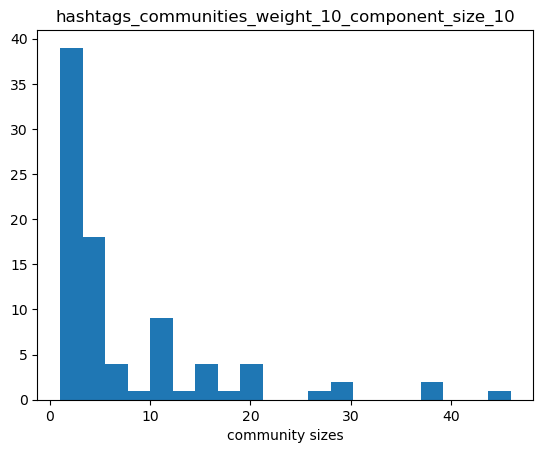

The community number 0:
{'#الشباب', '#اكشن_يا_دوري', '#الجوف', '#دوري_عبداللطيف_جميل', '#الاحساء', '#الاتحاد،', '#qatif', '#تركيا', '#رجال_الامن', '#الرياض', '#المدينة', '#الشرقية', '#الاهلي_الفيصلي', '#المطالبه_بإيقاف_عمر_السومة', '#ابها', '#الهلال_الشباب', '#حرس_الحدود', '#روسيا', '#بريدة', '#سوف', '#القطيف', '#جازان', '#تبوك', '#الاتحاد', '#الفيصلي', '#خميس_مشيط', '#النصر', '#الباحة', '#جدة', '#القصيم', '#ضيف_برو', '#نجران', '#saudi', '#وزارة_الداخلية', '#صدى_الملاعب', '#جراح_سوريا', '#السعودية', '#وزير_الداخلية', '#عسير', '#حائل', '#الدمام', '#الاهلي', '#الخليج', '#ksa', '#الهلال', '#مكة'}
The community number 1:
{'#amateur', '#sex', '#privatepics', '#sexy', '#adult', '#celebrities', '#livegirls', '#bigboobs', '#freeporn', '#girls', '#porngifs', '#erotic', '#booty', '#nude', '#fucking', '#dressedundressed', '#celebrity', '#porn', '#horny', '#teen', '#free', '#video', '#nsfw', '#anal', '#bigtits', '#naked', '#xxx', '#ass', '#hardcore', '#softcore', '#tits', '#selfshot', '#asian', '#

In [38]:
def network_w_c(G, weights=10,components=10, write=False):
    G_new = G.copy()
    edge_weights = nx.get_edge_attributes(G_new,'weight')
    # remove edges
    G_new.remove_edges_from((e for e, w in edge_weights.items() if w <weights))
    components_nodes = sorted(nx.connected_components(G_new), key=len, reverse=True)
    comm_list = np.array([len(c) for c in components_nodes])
    # remove small components
    for i in components_nodes:
        if len(i) < components:
            G_new.remove_nodes_from((n for n in i))
    # community detection
    cset = list(nx_comm.label_propagation_communities(G_new))
    final_comm_nodes = sorted(cset, key=len, reverse=True)
    final_comm_list = np.array([len(c) for c in final_comm_nodes])
    # plot the results
    plt.hist(final_comm_list, 20)
    plt.xlabel('community sizes')
    plt.title(f"hashtags_communities_weight_{weights}_component_size_{components}")
    plt.show()
    for ind, c in enumerate(final_comm_nodes):
        if len(c) >= components:
            print(f"The community number {ind}:")
            print(c)
    if write:
        out_name = 'htag_communities_w'+str(weights)+'_c'+str(components)+'.txt'
        with open(out_name, 'w', encoding='utf-8') as fout:
            for c in final_comm_nodes:
                if len(c)>=components:
                    strc = " ".join(c)
                    strc = "{"+strc+"}"+'\n'
                    fout.write(strc)
network_w_c(G)

### Community that makes sense; doesn't make sense

Make sense: I think both the cluster `4` and cluster `5` make sense to me. The two cluster are corresponding to `kpop` content and `fitness`. 


Doesn't make sense: The component `0` includes many hashtags from different fields. Some hashtags are about the thanksgiving holiday but some of them are football and business and jobs content.

The potential reason why it doesn't make sense is that there are many different types of hashtags mixing together. In the first giant components, some hashtags are gifts related such as #gift, #itunes, and some hashtags are related to jobs and business. I also see some sports related hashtags, like #nfl and #football. The first component is just a mixture of many topics, which makes it really hard to explain the meanings behind the component.

### Describe the strengths and weaknesses of each quadrant. present example communities from each to support comments

Q1 low weight low component size:
1. strength: because of low weight, the Q1 can capture as much as information it can. Even though some weak connections will be included in Q1. It's comprehensive;
2. weakness: Since the weight and component size would be large, the dataset would be noisy. It increases the opportunities to include meaningless components in the data.

The example: component No.9 is all about something including `beta`, although I am not familiar with it. 



Q2: high weight but low component size
1. strength: Q2 can capture more stable and strong connections, so basically all the components we obtain from Q2 are corresponding to same/similar topics. Beside,since the component size threshold is low, we can get as many as possible of the components with stable connections.

2. weakness: Q2 will have limited number of components, since the threshold of the weights is high. It may miss some weakly connected but meaningful components.

example: component No.3 is all about the digital devices or games (ipad, android, games etc).


Q3: low weight but high componentb size
1. strength: It can recognize large components with connections. Some items with weak connections can be displayed too.
2. weakness: However, because each hashtag may only have weak connections, so the large components may have meaningless information. 

In my example, the component No.1 has all the korean words. 


Q4: high weight and high component size

1. strength: the high threshold in both weight and component size will give us the strongest connections and largest comunities with similar interests.
2. weakness: The threshold is too high so that many communities have intermediate connections and size will be missed out. 

In my example, I only have one component. This component is majorly about the "retweeting" and "followback".


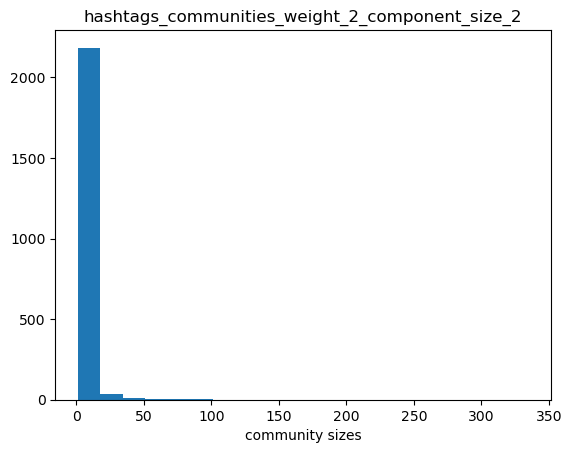

The community number 0:
{'#pnw', '#accounting', '#baytown', '#fresno', '#cleveland', '#-', '#franklin', '#kellyservices', '#orem', '#zftrw', '#media', '#cosmetics', '#onlinebiz', '#philadelphia', '#insurance', '#pharmacy', '#nettempsjobs', '#sales', '#cheshire', '#500k', '#ca', '#ottnews', '#canada', '#edwardsville', '#application', '#maintenance', '#fremont', '#truck', '#names', '#raleigh', '#teacher', '#smallbiz', '#real', '#businessmgmt', '#usajobs', '#carrollton', '#recruiting', '#bournemouth', '#account', '#columbus', '#england', '#sonic', '#therapist', '#utilities', '#riverside', '#regions', '#bakersfield', '#sydneynews', '#emplois', '#supervisor', '#ns', '#in', '#bilingual', '#orjobs', '#australia', '#leeds', '#cfgjobs', '#minneapolis', '#coordinator', '#engineering', '#sap', '#electrical', '#restaurant', '#extra', '#oxford', '#xrim', '#grandrapids', '#payroll', '#tenant', '#clerical', '#orlando', '#newhaven', '#london', '#documentary', '#freelance', '#perth', '#jacksonville', '

In [39]:
# Q1: low weight low component size
network_w_c(G, weights=2, components=2)

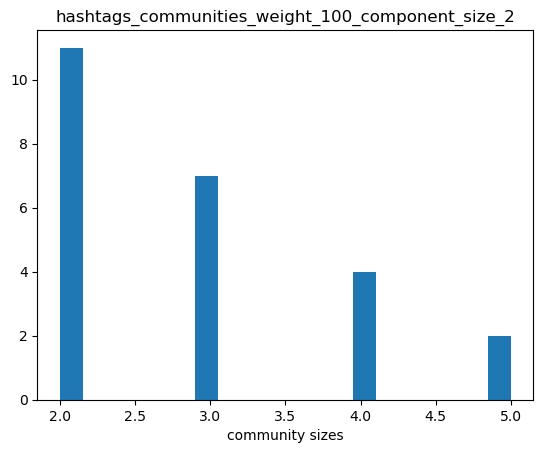

The community number 0:
{'#androidgames', '#ipad', '#gameinsight', '#android', '#ipadgames'}
The community number 1:
{'#tfw', '#teamfollowback', '#ff', '#tfb', '#rtした人全員フォローする'}
The community number 2:
{'#النصر', '#الاهلي', '#الاتحاد', '#الهلال'}
The community number 3:
{'#job', '#careerarc', '#hiring', '#jobs'}
The community number 4:
{'#mgwv', '#followtrick', '#follow', '#followback'}
The community number 5:
{'#الجمعة', '#نشر_سيرته', '#صورة', '#ﷺ'}
The community number 6:
{'#빅스', '#더쇼', '#사슬'}
The community number 7:
{'#mtvstars', '#grammys', '#videomtv2015'}
The community number 8:
{'#giveaway', '#competition', '#win'}
The community number 9:
{'#giosada', '#divanorolling', '#xf9'}
The community number 10:
{'#davide', '#luca', '#urbanstrangers'}
The community number 11:
{'#followme', '#sougofollow', '#followmejp'}
The community number 12:
{'#souhailabenlachhab', '#ihabamir', '#staracarabia'}
The community number 13:
{'#blackfriday', '#kohlssweepstakes'}
The community number 14:
{'#سك

In [40]:
# Q2: high weight, low component size
network_w_c(G, weights=100, components=2)

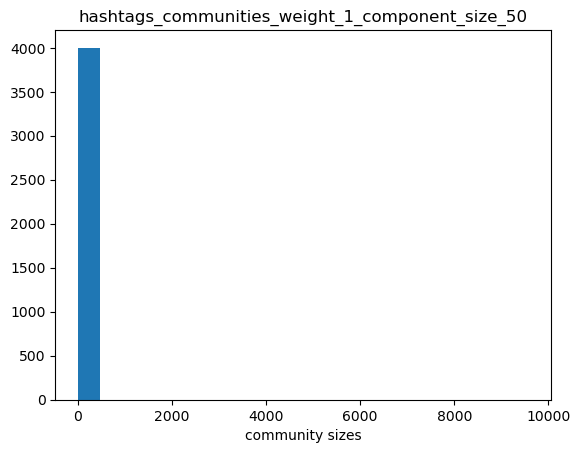

The community number 0:
{'#teamsmix', '#gtajobs', '#graciasdiospormifamilia', '#aromatherapypendant', '#rrbc', '#cuidadoconelangel', '#shouldacouldawoulda', '#hotels', '#strong', '#tdactu', '#coup', '#storewide', '#pie', '#love2shop', '#vsfashionshow', '#nowfollowing', '#blacklove', '#fresh', '#beats', '#kindleunlimited', '#craftnoodleteam', "#lions'", '#isla', '#sexytattoofriday', '#cape', '#atime4thanks', '#bayırbucaktürkmenleri', '#shake', '#personalblender', '#horizonwifi', '#5hreflectionmexico', '#mediachat', '#joke', '#missing', '#campaigns', '#kanyewest', '#answer', '#scam', '#skytree', '#xboxone', '#amusementparkengineer', '#miraclebabies', '#passports', '#canada', '#tg', '#googlestarwars', '#filmmaker', '#easybranches', '#cannabis', '#reading', '#truestory', '#soulvegetarian', '#demorou', '#owl', '#lublin', '#affiliate', '#producerlife', '#70s', '#uttarakhand', '#ipod-touch', '#avance', '#uni', '#filme', '#carseat', '#marvel', '#ukbff', '#katch', '#digitalagency', '#lesbo', '#

In [41]:
# Q3: low weight high component size
network_w_c(G, weights=1, components=50)

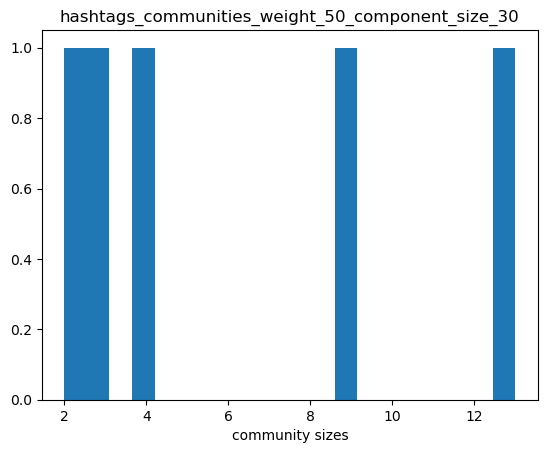

In [43]:
# Q4: high weight high component size
network_w_c(G, weights=50, components=30)

In [14]:
print(G)

Graph with 46753 nodes and 126663 edges


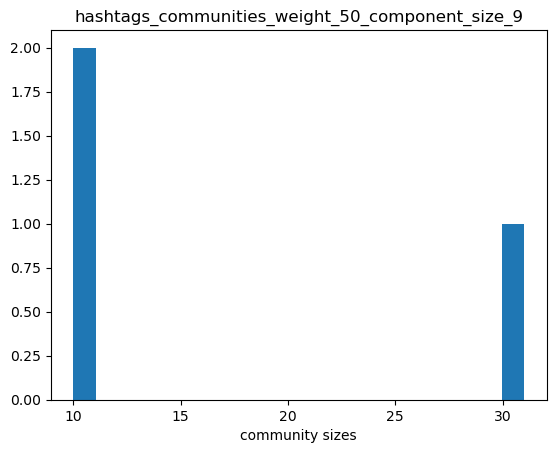

The component number 0:
{'#followmejp', '#tfw', '#相互フォロー', '#拡散希望', '#ff', '#noticias', '#mgwv', '#refollow', '#相互希望', '#sougofollow', '#retweet', '#followdaibosyu', '#news', '#followme', '#teamfollowback', '#rtした人全員フォローする', '#follow', '#tfb', '#祝ってくれる人rt', '#followall', '#kohlssweepstakes', '#rt', '#followback', '#advertising', '#marketing', '#giveaway', '#followtrick', '#competition', '#win', '#ふぁぼした人全員フォローする', '#blackfriday'}
The component number 1:
{'#السعودية', '#ايران', '#الرياض', '#المدينة', '#جدة', '#iran', '#ابها', '#ksa', '#saudi', '#اليمن', '#مكة'}
The component number 2:
{'#premiostelehit', '#5hpremiostelehit', '#squadgoalsworthit', '#lg5', '#yaass5h', '#5h2iscoming', '#mtvstars', '#videomtv2015', '#grammys', '#arias5sos'}
The component number 3:
{'#androidgames', '#ipad', '#apple', '#iphone', '#paradiseisland2', '#gameinsight', '#iphonegames', '#android', '#ipadgames'}
The component number 4:
{'#sales', '#hospitality', '#jobs', '#careerarc', '#veterans', '#healthcare', '#h

In [15]:
network_w_c(G, weights=50, components=9, write=False)

### Pick a topic/theme I see in the data. for each threshold, find the communities correspond best to the topic. which threshold? why? is there a best threshold? why or why not?

I am interested in topics about `digital devices & entertainment`. I tried several different thresholds in `weights` and `component size`. It turns out that when I give `weights= 50` and `components_size = 9`, I can have a relatively comprehensive results. If I set the `weights` too high, I will have a small `component size` so that not all the elements (hashtags here) can be included in my list; Besides, if I set the `component size` too high, I will totally miss the digital category. I think it could be an subjective optimized values for `weights` and `component size` to make sure we include all the hastags we want. The standard of the best threshold should satisfy that 
1. have stable and strong connections (relatively high weights)
2. have as many as similar hastags in the community

Just like I said, it's a subjective standard here, so there is no absolute answer. We don't want to miss too much similar hashtags in the community and at the same time we don't want some irrelevant hashtags contaminate the community. 
